# This notebook investigates usage during the ADV Revival 2 Tournament

Start with standard python imports

In [1]:
import pandas as pd
import numpy as np
import sys
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import fisher_exact, chi2_contingency

sys.path.append("../..")
from utils import download_replay, parse_single_replay

In [2]:
APPERANCE_THRESHOLD = 44

In [3]:
# Setup logger
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
)
logger = logging.getLogger(__name__)

## Download and parse the replays

In [4]:
data_folder = "data/"
replay_log = pd.read_csv(f"{data_folder}ADV Revival 2 - Importer.csv", index_col=0)

In [5]:
len(replay_log)

4380

In [6]:
bracket_replay_min = 4331
round_six_min = 3533

In [7]:
all_observed_pokemon = pd.DataFrame()
for replay in replay_log.iterrows():

    if replay[0] % 100 == 0:
        logger.info(f"Processing replay {replay[0]}")

    # Download the replay

    filename = download_replay(
        replay[1]["Replay Link"].strip().split("?")[0] + ".json", data_folder
    )
    if filename is None:
        continue
    # Parse the replay
    single_game_pokemon = parse_single_replay(
        replay_path=data_folder + filename, game_id=replay[0]
    )
    all_observed_pokemon = pd.concat(
        [all_observed_pokemon, single_game_pokemon], ignore_index=True
    )

2025-04-05 14:10:24,226 - INFO - Processing replay 100
2025-04-05 14:10:29,470 - INFO - Processing replay 200
2025-04-05 14:10:34,498 - INFO - Processing replay 300
2025-04-05 14:10:39,556 - INFO - Processing replay 400
2025-04-05 14:10:44,543 - INFO - Processing replay 500
2025-04-05 14:10:49,591 - INFO - Processing replay 600
2025-04-05 14:10:54,781 - INFO - Processing replay 700
2025-04-05 14:10:59,941 - INFO - Processing replay 800
2025-04-05 14:11:05,788 - INFO - Processing replay 900
2025-04-05 14:11:11,491 - INFO - Processing replay 1000
2025-04-05 14:11:17,322 - INFO - Processing replay 1100
2025-04-05 14:11:21,617 - WARNING - URL https://match.conceeded.to.pkLeech.json does not contain 'replay'. Skipping download.
2025-04-05 14:11:23,018 - INFO - Processing replay 1200
2025-04-05 14:11:28,693 - INFO - Processing replay 1300
2025-04-05 14:11:34,480 - INFO - Processing replay 1400
2025-04-05 14:11:40,111 - INFO - Processing replay 1500
2025-04-05 14:11:45,867 - INFO - Processing

Start with somewhat generic summary statistics for usage rates

In [13]:
# Usage Rates for most common pokemon
base_usage = all_observed_pokemon["species"].value_counts()/(2*all_observed_pokemon['game_id'].nunique())
# Usage Rates on winning teams
winning_usage = all_observed_pokemon.loc[all_observed_pokemon["won"]]["species"].value_counts()/(all_observed_pokemon.loc[all_observed_pokemon["won"]]['game_id'].nunique())

rates = pd.merge(
    base_usage.rename("base_usage"),
    winning_usage.rename("winning_usage"),
    left_index=True,
    right_index=True,
)

# Overall win rates per pokemon (filtered to those used in APPERANCE_THRESHOLD+ games)
pivot_table = pd.pivot_table(
    all_observed_pokemon,
    values='game_id',
    index='species',
    columns='won',
    aggfunc='count',
    fill_value=0
)

pivot_table.columns = ['Lost', 'Won']
pivot_table = pivot_table[(pivot_table['Lost'] + pivot_table['Won']) >= APPERANCE_THRESHOLD]
pivot_table['win_rate'] = pivot_table['Won'] / (pivot_table['Won'] + pivot_table['Lost'])
rates = pd.merge(
    rates,
    pivot_table['win_rate'].rename("win_rate"),
    left_index=True,
    right_index=True,
)
# Base win rate on a per-pokemon level is <0.5 because you're more likely to reveal all 6 pokemon in a loss
base_win_rate = (all_observed_pokemon['won'].mean())
rates['net_win_rate'] = rates['win_rate'] - base_win_rate

In [23]:
rates.head(10)

,base_usage,winning_usage,win_rate,net_win_rate
species,,,,
Tyranitar,0.545216,0.545017,0.498220,0.016912
Metagross,0.397694,0.378007,0.473730,-0.007579
Swampert,0.375999,0.374800,0.496811,0.015503
Skarmory,0.362069,0.361970,0.498266,0.016957
Zapdos,0.334095,0.325315,0.485304,0.003996
Blissey,0.304864,0.302405,0.494382,0.013074
Salamence,0.294017,0.288660,0.489320,0.008012
Celebi,0.247088,0.243070,0.490296,0.008988
Suicune,0.243092,0.243299,0.498826,0.017518


In [25]:
rates.sort_values("net_win_rate", ascending=False).head(10)

,base_usage,winning_usage,win_rate,net_win_rate
species,,,,
Registeel,0.011532,0.012371,0.534653,0.053345
Smeargle,0.021009,0.021764,0.516304,0.034996
Regirock,0.018155,0.018786,0.515723,0.034415
Jynx,0.021009,0.021535,0.510870,0.029561
Claydol,0.178694,0.181214,0.505431,0.024123
Milotic,0.053094,0.053837,0.505376,0.024068
Jirachi,0.192510,0.195189,0.505338,0.024030
Houndoom,0.012332,0.012371,0.500000,0.018692
Suicune,0.243092,0.243299,0.498826,0.017518


In [24]:
rates

,base_usage,winning_usage,win_rate,net_win_rate
species,,,,
Tyranitar,0.545216,0.545017,0.498220,0.016912
Metagross,0.397694,0.378007,0.473730,-0.007579
Swampert,0.375999,0.374800,0.496811,0.015503
Skarmory,0.362069,0.361970,0.498266,0.016957
Zapdos,0.334095,0.325315,0.485304,0.003996
Blissey,0.304864,0.302405,0.494382,0.013074
Salamence,0.294017,0.288660,0.489320,0.008012
Celebi,0.247088,0.243070,0.490296,0.008988
Suicune,0.243092,0.243299,0.498826,0.017518


In [36]:
# Overall move usage rates
# chance the move is used by a given team
pd.concat([all_observed_pokemon['move 1'], all_observed_pokemon['move 2'], all_observed_pokemon['move 3'], all_observed_pokemon['move 4']], axis=0).value_counts().head(20)/(2*all_observed_pokemon['game_id'].nunique())

Earthquake      0.682119
Thunderbolt     0.588605
Hidden Power    0.575245
Rock Slide      0.472596
Ice Beam        0.458438
Spikes          0.438570
Protect         0.382622
Toxic           0.360813
Surf            0.326330
Explosion       0.304636
Calm Mind       0.299041
Roar            0.294131
Substitute      0.259763
Meteor Mash     0.241950
Hydro Pump      0.239438
Thunder Wave    0.232016
Baton Pass      0.217858
Dragon Dance    0.205412
Focus Punch     0.198790
Fire Blast      0.195022
Name: count, dtype: float64

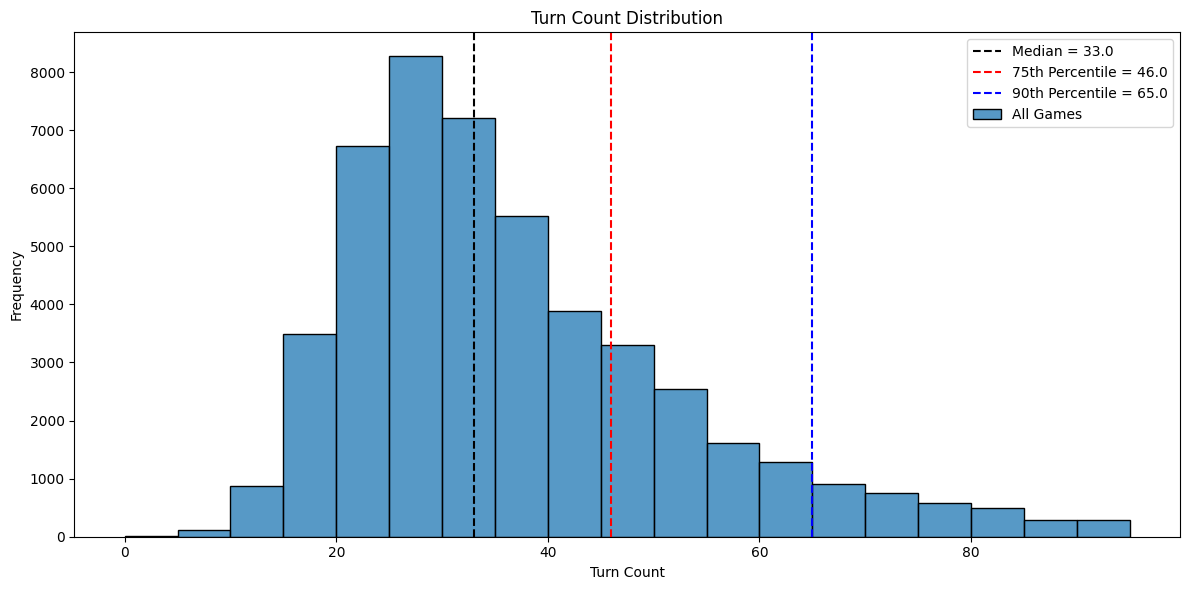

In [35]:
# Histogram of turn counts
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(
    all_observed_pokemon["turn_count"],
    bins=np.arange(0, 100, 5),
    ax=ax,
    label="All Games",
)
ax.axvline(all_observed_pokemon["turn_count"].quantile(0.5), color="black", linestyle="--", label=f"Median = {all_observed_pokemon["turn_count"].quantile(0.5)}")
ax.axvline(all_observed_pokemon["turn_count"].quantile(0.75), color="red", linestyle="--", label=f"75th Percentile = {all_observed_pokemon["turn_count"].quantile(0.75)}")
ax.axvline(all_observed_pokemon["turn_count"].quantile(0.9), color="blue", linestyle="--", label=f"90th Percentile = {all_observed_pokemon["turn_count"].quantile(0.9)}")
ax.set_title("Turn Count Distribution")
ax.set_xlabel("Turn Count")
ax.set_ylabel("Frequency")
ax.legend()
plt.tight_layout()
plt.show()

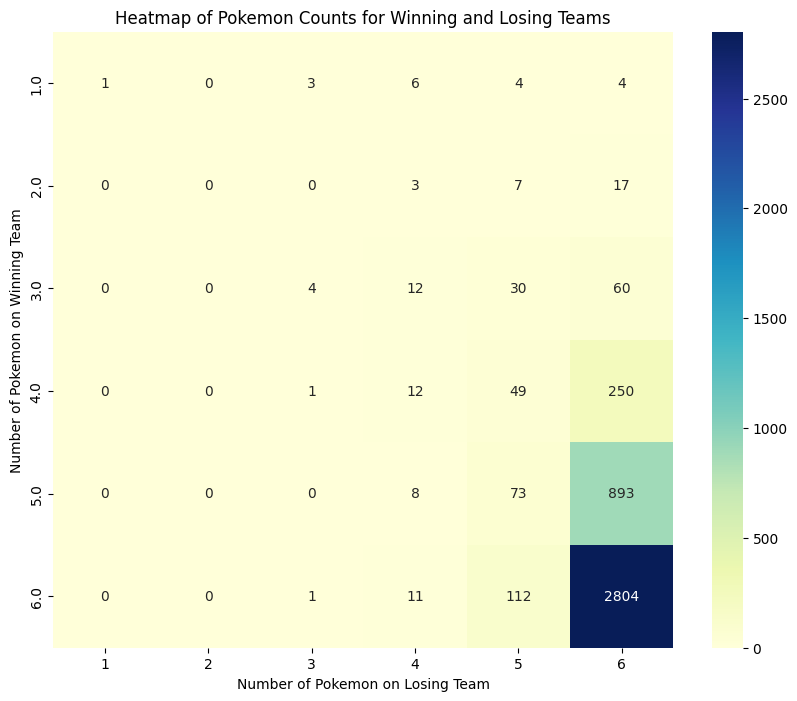

In [32]:
# Number of revealed pokemon per game
species_counts = all_observed_pokemon.groupby(['game_id','won'])[['species']].count().reset_index().set_index('game_id')

heatmap_data = species_counts.pivot_table(
    index=species_counts.loc[species_counts['won'], 'species'],
    columns=species_counts.loc[~species_counts['won'], 'species'],
    aggfunc='size',
    fill_value=0
)/2

for i in range(1,7):
    if i not in heatmap_data.index:
        heatmap_data.loc[i] = 0
    if i not in heatmap_data.columns:
        heatmap_data[i] = 0

heatmap_data = heatmap_data.sort_index(axis=0).sort_index(axis=1)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu", cbar=True)

# Add labels and title
plt.ylabel("Number of Pokemon on Winning Team")
plt.xlabel("Number of Pokemon on Losing Team")
plt.title("Heatmap of Pokemon Counts for Winning and Losing Teams")
plt.show()


In [33]:
# Pokemon by the average number of revealed moves
all_observed_pokemon['revealed_moves'] = 4-all_observed_pokemon.isna().sum(axis=1)
pivot_table = pd.pivot_table(
    all_observed_pokemon,
    values='revealed_moves',
    index='species',
    aggfunc=['mean', 'count'],
    fill_value=0
)

pivot_table = pivot_table[(pivot_table[('count', 'revealed_moves')] >= APPERANCE_THRESHOLD)]
pivot_table.sort_values(('mean', 'revealed_moves'), ascending=False)

,mean,count
,revealed_moves,revealed_moves
species,,
Venusaur,2.472222,108
Blissey,2.453558,2670
Jynx,2.369565,184
Misdreavus,2.358209,67
Smeargle,2.326087,184
Umbreon,2.319444,72
Skarmory,2.312520,3171
Milotic,2.290323,465


2025-04-05 14:20:37,661 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-05 14:20:37,669 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


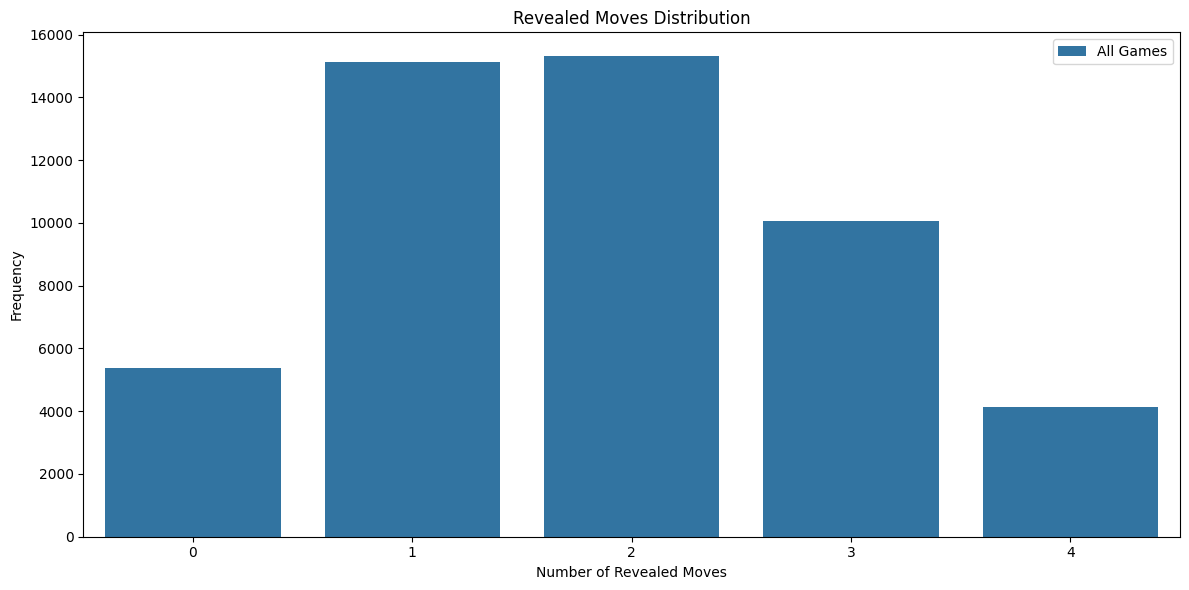

In [34]:
revealed_move_counts = all_observed_pokemon.groupby("revealed_moves")['won'].count()
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(
    x=revealed_move_counts.index,
    y=revealed_move_counts.values,
    ax=ax,
    label="All Games",
)
ax.set_title("Revealed Moves Distribution")
ax.set_xlabel("Number of Revealed Moves")
ax.set_ylabel("Frequency")
ax.legend()
plt.tight_layout()
plt.show()

Now it's time for some deeper statistics

In [18]:
teams = all_observed_pokemon.groupby(['game_id', 'won'])['species'].apply(list).reset_index()

In [20]:
pkmn_is_seen_frequently = (all_observed_pokemon.groupby("species").count()['game_id'] > APPERANCE_THRESHOLD)
frequent_pokemon = pkmn_is_seen_frequently[pkmn_is_seen_frequently].index

In [21]:
frequent_pokemon

Index(['Aerodactyl', 'Blaziken', 'Blissey', 'Breloom', 'Camerupt', 'Celebi',
       'Charizard', 'Claydol', 'Cloyster', 'Dugtrio', 'Dusclops', 'Flygon',
       'Forretress', 'Gengar', 'Glalie', 'Gyarados', 'Hariyama', 'Heracross',
       'Houndoom', 'Jirachi', 'Jolteon', 'Jynx', 'Kingdra', 'Ludicolo',
       'Machamp', 'Magneton', 'Marowak', 'Medicham', 'Metagross', 'Milotic',
       'Misdreavus', 'Moltres', 'Porygon2', 'Raikou', 'Regice', 'Regirock',
       'Registeel', 'Salamence', 'Skarmory', 'Slaking', 'Smeargle', 'Snorlax',
       'Starmie', 'Steelix', 'Suicune', 'Swampert', 'Tyranitar', 'Umbreon',
       'Vaporeon', 'Venusaur', 'Weezing', 'Zapdos'],
      dtype='object', name='species')

In [26]:
# Of all the pokemon that appear often enough, which change your chance of winning?
for frequent in frequent_pokemon:
    teams['has'] = teams['species'].apply(lambda x: frequent in x)
    # Perform Fisher's Exact Test
    contingency_table = pd.crosstab(teams['won'], teams['has'])
    odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')
    if p_value < 0.05/len(frequent_pokemon):
        logger.info(f"Pokemon: {frequent}, Odds Ratio: {odds_ratio}, p-value: {p_value}")

2025-04-05 14:19:47,875 - INFO - Pokemon: Aerodactyl, Odds Ratio: 0.8068665801580748, p-value: 0.0001101739356552017
2025-04-05 14:19:48,134 - INFO - Pokemon: Gengar, Odds Ratio: 0.8349931040317701, p-value: 0.0003418740261183368
2025-04-05 14:19:48,232 - INFO - Pokemon: Heracross, Odds Ratio: 0.6622191122685269, p-value: 2.9373419614576043e-06
2025-04-05 14:19:48,505 - INFO - Pokemon: Metagross, Odds Ratio: 0.8473065920754933, p-value: 0.00015674848711447924


4 do and they all make your team worse. Aerodactyl, Gengar, Heracross, and Metagross

In [27]:
tall_by_move = all_observed_pokemon.melt(
    id_vars=["game_id", "won", "species"],
    value_vars=["move 1", "move 2", "move 3", "move 4"],
    var_name="move_number",
    value_name="move",
).dropna()

In [28]:
pkmn_move_is_seen_frequently = (tall_by_move.groupby(["species", 'move']).count()['game_id'] > APPERANCE_THRESHOLD)
frequent_pkmn_move = pkmn_move_is_seen_frequently[pkmn_move_is_seen_frequently].index


In [29]:
# Are there any moves that make a pokemon perform differently?
for frequent_pkmn, frequent_move in frequent_pkmn_move:
    targets = tall_by_move.loc[(tall_by_move["species"] == frequent_pkmn)]
    moves_of_targets = targets.groupby(["game_id", "won"])["move"].unique().reset_index()
    moves_of_targets['has_move'] = moves_of_targets['move'].apply(lambda x: frequent_move in x)
    # Perform Fisher's Exact Test
    contingency_table = pd.crosstab(moves_of_targets['won'], moves_of_targets['has_move'])
    if contingency_table.shape != (2,2):
        continue
    odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')
    if p_value < 0.05/len(frequent_pkmn_move):
        logger.info(f"Pokemon: {frequent_pkmn} Move: {frequent_move}, Odds Ratio: {odds_ratio}, p-value: {p_value}")

2025-04-05 14:19:52,581 - INFO - Pokemon: Aerodactyl Move: Rock Slide, Odds Ratio: 0.6209889760134255, p-value: 1.7469788374258754e-05
2025-04-05 14:19:56,640 - INFO - Pokemon: Celebi Move: Giga Drain, Odds Ratio: 1.4729519610118358, p-value: 9.83601570400787e-05
2025-04-05 14:20:17,661 - INFO - Pokemon: Skarmory Move: Spikes, Odds Ratio: 1.792853625940775, p-value: 4.118270199715508e-05


In [41]:
# Are there pokemon with statistically different win rates in the main pool and the final bracket
all_observed_pokemon['is_final_bracket'] = all_observed_pokemon['game_id'] >= bracket_replay_min
teams['is_final_bracket'] = teams['game_id'] >= bracket_replay_min
final_bracket_teams = teams.loc[teams['is_final_bracket']].copy()
distributions = pd.crosstab(
    all_observed_pokemon['species'],
    all_observed_pokemon['is_final_bracket'],
)
distributions = distributions.rename(columns={True: "Final Bracket", False: "Main Pool"})
distributions = distributions.loc[distributions["Final Bracket"] > 5]

if chi2_contingency(distributions).pvalue > 0.05:
    logger.info("No statistically significant difference in usage rates")
else:
    logger.info("Statistically significant difference in usage rates")
    # Perform post-hoc analysis to determine which pokemon are different
    for pkmn in distributions.index:
        teams['has'] = teams['species'].apply(lambda x: pkmn in x)
        # Perform Fisher's Exact Test
        contingency_table = pd.crosstab(teams['is_final_bracket'], teams['has'])
        if contingency_table.shape != (2,2):
            continue
        odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')
        if p_value < 0.05/len(distributions.index):
            logger.info(f"Pokemon: {pkmn}, Occurance Odds Ratio: {odds_ratio}, p-value: {p_value}")

        final_bracket_teams = teams.loc[teams['is_final_bracket']].copy()
        # Perform Fisher's Exact Test
        contingency_table = pd.crosstab(final_bracket_teams['won'], final_bracket_teams['has'])
        odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')
        if p_value < 0.05/len(distributions.index):
            logger.info(f"Pokemon: {pkmn}, Wins Odds Ratio: {odds_ratio}, p-value: {p_value}")

2025-04-05 14:34:42,259 - INFO - Statistically significant difference in usage rates
2025-04-05 14:34:42,623 - INFO - Pokemon: Milotic, Occurance Odds Ratio: 3.4765086435465054, p-value: 6.771576366339375e-05


There is a difference between in which pokemon were used in the main pool play and the final bracket. Furthermore no individual pokemon had a statistically significant win differential in the final bracket anymore. Small sample sizes may be a contributing factor here.

In [43]:
# Are there pokemon with statistically different win rates in the main pool and the final bracket
all_observed_pokemon['is_back_half'] = all_observed_pokemon['game_id'] >= round_six_min
teams['is_back_half'] = teams['game_id'] >= round_six_min
back_half_teams = teams.loc[teams['is_back_half']].copy()
distributions = pd.crosstab(
    all_observed_pokemon['species'],
    all_observed_pokemon['is_back_half'],
)
distributions = distributions.rename(columns={True: "Back Half", False: "Main Pool"})
distributions = distributions.loc[distributions["Back Half"] > APPERANCE_THRESHOLD/2]

pvalue = chi2_contingency(distributions).pvalue
if pvalue > 0.05:
    logger.info("No statistically significant difference in usage rates")
else:
    logger.info(f"Statistically significant difference in usage rates {pvalue}")
    # Perform post-hoc analysis to determine which pokemon are different
    for pkmn in distributions.index:
        teams['has'] = teams['species'].apply(lambda x: pkmn in x)
        # Perform Fisher's Exact Test
        contingency_table = pd.crosstab(teams['is_back_half'], teams['has'])
        if contingency_table.shape != (2,2):
            continue
        odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')
        if p_value < 0.05/len(distributions.index):
            logger.info(f"Pokemon: {pkmn}, Occurance Odds Ratio: {odds_ratio}, p-value: {p_value}")

        back_half_teams = teams.loc[teams['is_back_half']].copy()
        # Perform Fisher's Exact Test
        contingency_table = pd.crosstab(back_half_teams['won'], back_half_teams['has'])
        odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')
        if p_value < 0.05/len(distributions.index):
            logger.info(f"Pokemon: {pkmn}, Odds Ratio: {odds_ratio}, p-value: {p_value}")

2025-04-05 14:35:50,629 - INFO - Statistically significant difference in usage rates 8.514243183759457e-10
2025-04-05 14:35:50,647 - INFO - Pokemon: Aerodactyl, Occurance Odds Ratio: 0.7627926030929966, p-value: 0.00021171378585853
2025-04-05 14:35:50,982 - INFO - Pokemon: Hariyama, Occurance Odds Ratio: 0.530813540598122, p-value: 5.9297879489289974e-05
2025-04-05 14:35:51,032 - INFO - Pokemon: Jirachi, Occurance Odds Ratio: 1.3959241349899891, p-value: 4.4711408261603994e-07


Same deal when you look at the front half of the bracket vs the back. Still a significant distribution difference in usage rates but no longer any significant difference in win rates for any individual pokemon.